In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from combiners import EpochsCombiner
from typing import *
import mne
import tensorflow as tf
import mneflow as mf
import matplotlib.pyplot as plt
import numpy as np

2022-02-10 20:17:43.324886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 20:17:43.324928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder
import pickle

def read_pkl(path: str) -> Any:
    with open(
            path,
            'rb'
        ) as file:
        content = pickle.load(
            file
        )
    return content

spatial_parameters = read_pkl('../Source/Subjects/Ga_Fed_06/Parameters/LM&LI_vs_RM&RI_B1-B8_spatial.pkl')
temporal_parameters = read_pkl('../Source/Subjects/Ga_Fed_06/Parameters/LM&LI_vs_RM&RI_B1-B8_temporal.pkl')
orders = read_pkl('../Source/Subjects/Ga_Fed_06/Parameters/LM&LI_vs_RM&RI_B1-B8_sorting.pkl')
info = read_pkl('../Source/Subjects/Ga_Fed_06/Info/ML_Subject06_P1_tsss_mc_trans_info.pkl')
original_info = info.copy()

In [3]:
def plot_patterns(patterns, info, order=None, axes=None, cmap='RdBu_r', sensors=True,
                colorbar=False, res=64,
                size=1, cbar_fmt='%3.1f', name_format='Latent\nSource %01d',
                show=True, show_names=False, title=None,
                outlines='head', contours=6,
                image_interp='bilinear'):
    
    if order is None:
        order = range(patterns.shape[1])
    
    if title is None:
        title=f'Computed patterns'
    
    import copy
    info = copy.deepcopy(info)
    info['sfreq'] = 1.
    patterns = mne.EvokedArray(patterns, info, tmin=0)
    topoplot_params = dict(
            times=order,
            cmap=cmap, colorbar=colorbar, res=res,
            cbar_fmt=cbar_fmt, sensors=sensors, units=None, time_unit='s',
            time_format=name_format, size=size, show_names=show_names,
            title=title, outlines=outlines,
            contours=contours, image_interp=image_interp, show=show
    )
    if axes is not None:
        topoplot_params.update(dict(axes=axes))
    return patterns.plot_topomap(**topoplot_params)

In [3]:

info = original_info.copy()
info.pick_channels(
    list(
        filter(
            lambda ch_name: (ch_name[-1] == '2' or ch_name[-1] == '3') and 'meg' in ch_name.lower(),
            info['ch_names']
        )
    )
)

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0122, MEG0123, MEG0132, MEG0133, MEG0143, ...
 chs: 204 GRAD
 custom_ref_applied: False
 description: Vectorview system
 dev_head_t: MEG device -> head transform
 dig: 90 items (3 Cardinal, 4 HPI, 83 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2018-11-27 12:27:25 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proc_history: 2 items (list)
 proj_id: 1 item (ndarray)
 proj_name: russell
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 6 items (dict)
>

In [60]:
# orders.l2[0].ravel()

orders

ComponentsOrder(l2=(array([[16],
       [29]]), array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])), commpwise_loss=(None, None), weight=(array([[23],
       [ 0]]), array([[12],
       [ 9]])), output_corr=(array([[16],
       [16]]), array([[14],
       [16]])), weight_corr=(array([[16],
       [ 0]]), array([[14],
       [ 9]])))

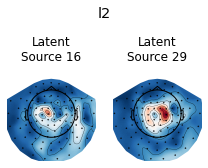

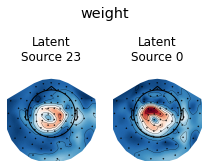

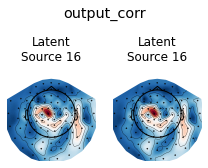

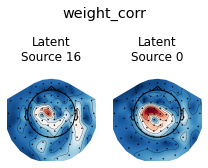

In [235]:
fig = plot_patterns(spatial_parameters.patterns, info, orders.l2[0].ravel(), title='l2')
fig = plot_patterns(spatial_parameters.patterns, info, orders.weight[0].ravel(), title='weight')
fig = plot_patterns(spatial_parameters.patterns, info, orders.output_corr[0].ravel(), title='output_corr')
fig = plot_patterns(spatial_parameters.patterns, info, orders.weight_corr[0].ravel(), title='weight_corr')

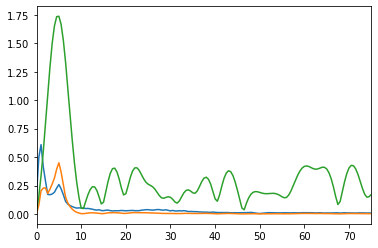

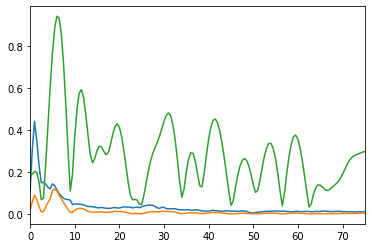

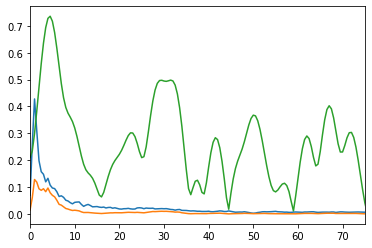

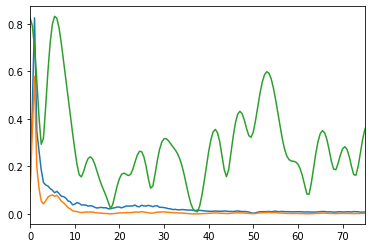

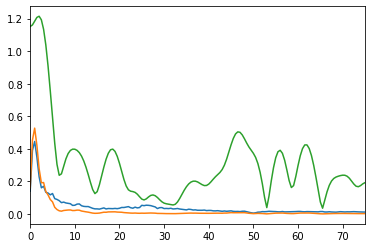

In [63]:


for fin, fout, fresp in zip(temporal_parameters.finputs[:5], temporal_parameters.foutputs[:5], temporal_parameters.fresponces[:5]):
    plt.plot(
        temporal_parameters.franges, fin,
        temporal_parameters.franges, fout,
        temporal_parameters.franges, fresp,
        )
    plt.xlim(0, 75)
    plt.show()

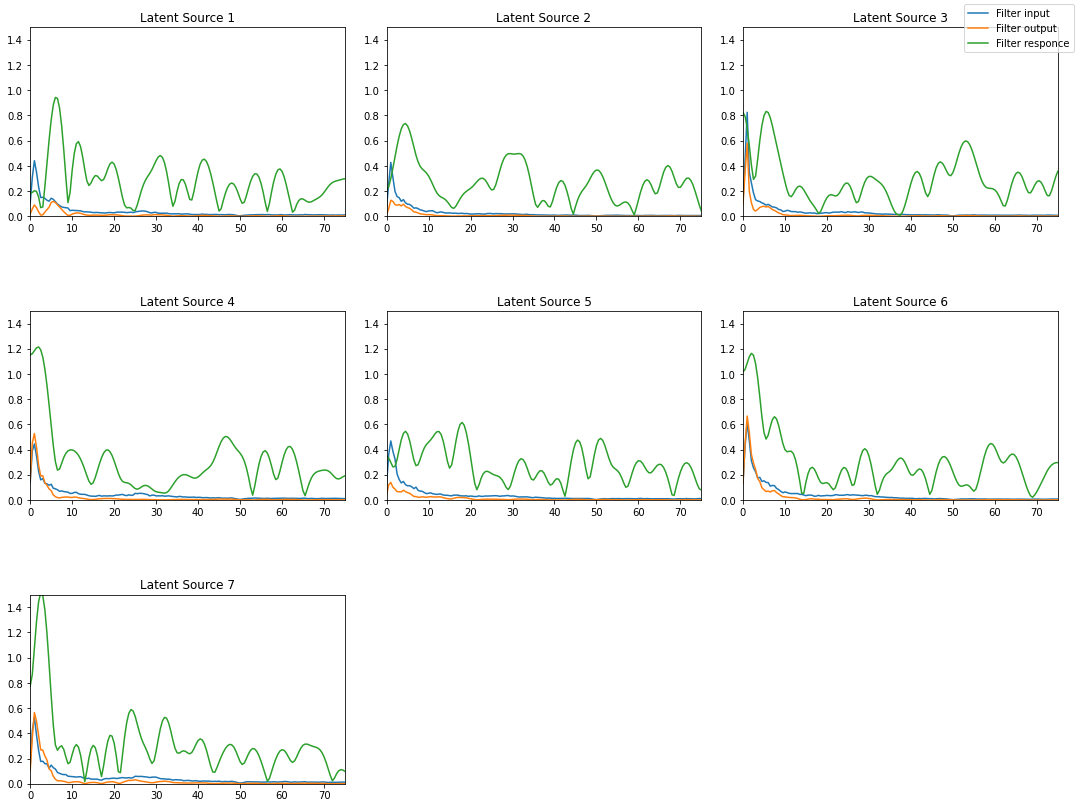

In [6]:
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)

# fig, axs = plt.subplots(1, 2)
# fig.set_size_inches(18.5, 5)
# fig.suptitle('Horizontally stacked subplots')
# axs[0].plot(x, y)
# axs[1].plot(x, -y)


def plot_spectra(temporal_parameters, order, title='', xlim=None, ylim=None, legend=None):
    
    if not len(order)%3:
        n_cols = 3
        n_rows = len(order)//3
    elif not len(order)%2:
        n_cols = 2
        n_rows = len(order)//2
    elif len(order) == 3:
        n_rows = 1
        n_cols = 3
    else:
        n_rows = len(order)//3+1
        n_cols = 3
    
    if legend is None:
        legend = ['Filter input', 'Filter output', 'Filter responce']
    
    fig, axs = plt.subplots(n_rows, n_cols)
    if len(axs.shape) == 1:
        axs = np.reshape(axs, (1, -1))
    
    fig.set_size_inches(n_cols*5, n_rows*3.75)
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
    
    
    
    current_comp = 0
    for i in range(n_rows):
        for j in range(n_cols):
            
            if current_comp < len(order):
                n_component = order[current_comp]
                axs[i, j].set_title(f'Latent Source {n_component}')
                axs[i, j].plot(
                    temporal_parameters.franges,
                    temporal_parameters.finputs[n_component],
                    temporal_parameters.franges,
                    temporal_parameters.foutputs[n_component],
                    temporal_parameters.franges,
                    temporal_parameters.fresponces[n_component],
                )
                
                if xlim:
                    axs[i, j].set_xlim(xlim)
                
                if ylim:
                    axs[i, j].set_ylim(ylim)
            else:
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                axs[i, j].spines['top'].set_visible(False)
                axs[i, j].spines['right'].set_visible(False)
                axs[i, j].spines['bottom'].set_visible(False)
                axs[i, j].spines['left'].set_visible(False)
            
            current_comp += 1
    
    fig.legend(legend, loc='upper right')
    
    return fig

plot_spectra(temporal_parameters, np.array([1, 2, 3, 4, 5, 6, 7]), xlim=[0, 75], ylim=[0, 1.5])

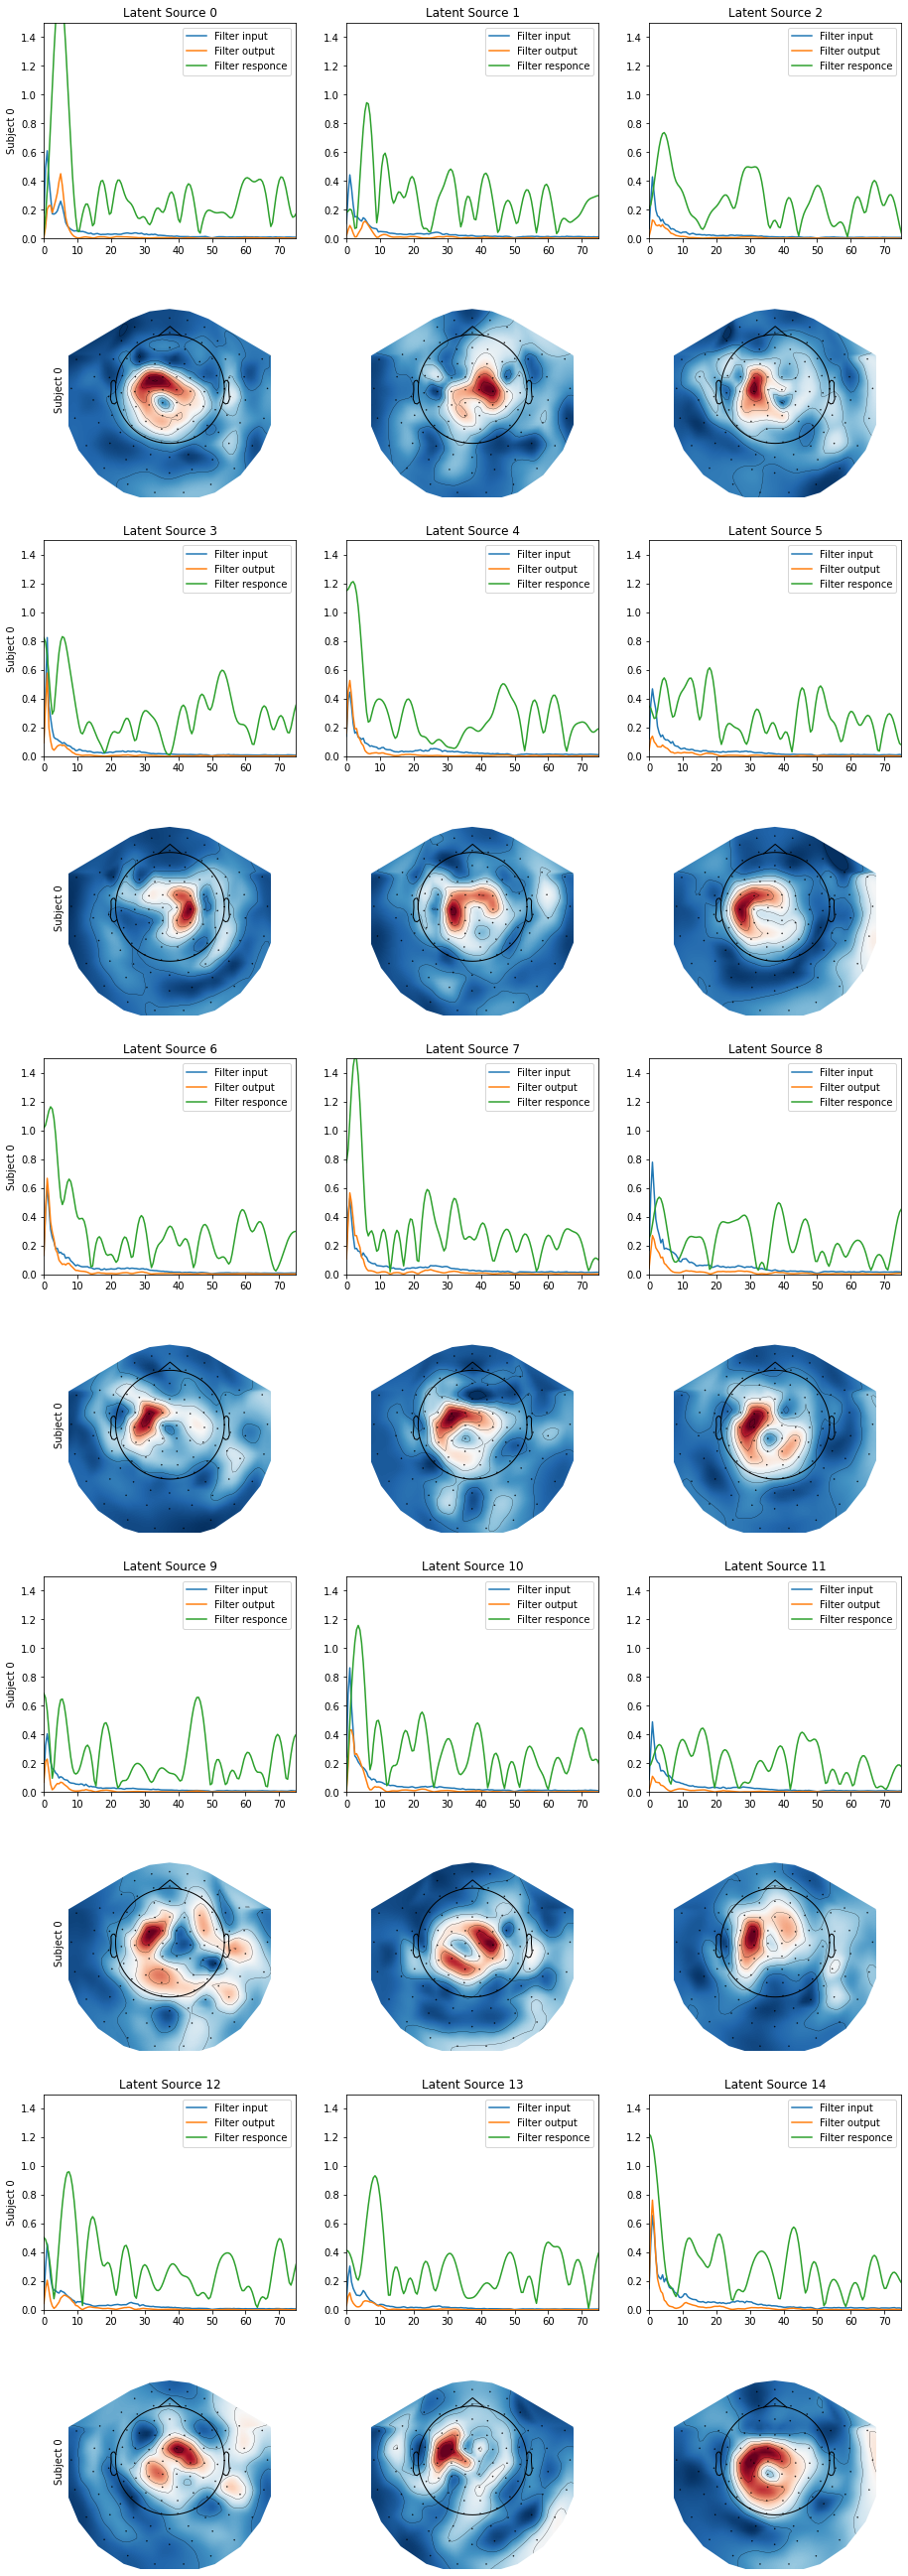

In [8]:
from collections import namedtuple
from dataclasses import dataclass
import matplotlib as mp
from typing import *
import copy

def plot_tempospectral(
    spatial_parameters: Union[SpatialParameters, list[SpatialParameters]],
    temporal_parameters: Union[TemporalParameters, list[TemporalParameters]],
    orders: Union[np.ndarray, list[np.ndarray]],
    info: mne.Info,
    subject_names: Optional[Union[str, list[str]]] = None,
    title: Optional[str] = '',
    xlim: Optional[Union[int, float]] = None,
    ylim: Optional[Union[int, float]] = None,
    legend: Optional[Union[int, float]] = None,
    topomap_kwargs: Optional[dict] = None
) -> mp.figure.Figure:
    
    def wrap_in_list(content):
        return [content] if not isinstance(content, list) else content
    
    def validate_length(*iterables):
        length = len(iterables[0])
        for i, sample in enumerate(iterables[1:]):
            if len(sample) != length:
                raise ValueError(f'Length validation failed: all elements must have length equal to {length}, but element {i} has length: {len(sample)}')
        return length

    spatial_parameters = wrap_in_list(spatial_parameters)
    temporal_parameters = wrap_in_list(temporal_parameters)
    if isinstance(orders, np.ndarray):
        n_components = len(orders)
    elif isinstance(orders[0], np.ndarray):
        n_components = len(orders[0])
    else:
        raise ValueError('"orders" must be either np.ndarray or list of np.ndarray')
    orders = wrap_in_list(orders)
    n_subjects = validate_length(spatial_parameters, temporal_parameters, orders)
    
    if subject_names is None:
        subject_names = [f'Subject {i}' for i in range(n_subjects)]
    elif isinstance(subject_names, str):
        subject_names = [f'{subject_names} {i}' for i in range(n_subjects)]
    elif isinstance(subject_names, list):
        if len(subject_names) != n_subjects:
            raise ValueError('Not all subjects have names provided')
    
    if not n_components%3:
        n_cols = 3
        n_rows = n_components//3
    elif not n_components%2:
        n_cols = 2
        n_rows = n_components//2
    elif n_components == 3:
        n_rows = 1
        n_cols = 3
    else:
        n_rows = n_components//3+1
        n_cols = 3
    
    n_rows_per_subject = 2*n_rows
    n_rows = n_subjects*n_rows_per_subject
    if legend is None:
        legend = ['Filter input', 'Filter output', 'Filter responce']
    
    fig, axs = plt.subplots(n_rows, n_cols)
    if len(axs.shape) == 1:
        axs = np.reshape(axs, (1, -1))
    
    fig.set_size_inches(n_cols*5, n_rows*3.75)
    
    # fig.tight_layout()
    # fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.5)
    
    subplots_map = np.ones((n_rows, n_cols)).astype(bool)

    current_comp = 0
    for i in range(0, n_rows, 2):
        for j in range(n_cols):
            
            if current_comp >= n_components:
                subplots_map[i, j], subplots_map[i+1, j] = False, False
                
            current_comp += 1
            
        if current_comp >= n_components:
            current_comp = 0
    
    @dataclass
    class Tracker(object):
        top: int
        bottom: int
        subject: int
        
    tracker = Tracker(0, 0, 0)
    for i in range(n_rows):
        for j in range(n_cols):
            
            if subplots_map[i, j]:
                
                if i%2 and j == 0:
                    axs[i, j].set_ylabel(subject_names[tracker.subject])
                    axs[i, j].tick_params(axis='y', pad=300)
                elif not i%2 and j == 0:
                    axs[i, j].set_ylabel(subject_names[tracker.subject])
                    
                if not i%2:
                    axs[i, j].set_title(f'Latent Source {orders[tracker.subject][tracker.top]}')
                    axs[i, j].plot(
                        temporal_parameters[tracker.subject].franges,
                        temporal_parameters[tracker.subject].finputs[orders[tracker.subject][tracker.top]],
                        temporal_parameters[tracker.subject].franges,
                        temporal_parameters[tracker.subject].foutputs[orders[tracker.subject][tracker.top]],
                        temporal_parameters[tracker.subject].franges,
                        temporal_parameters[tracker.subject].fresponces[orders[tracker.subject][tracker.top]],
                    )
                    
                    axs[i, j].legend(legend, loc='upper right')
                    
                    if xlim:
                        axs[i, j].set_xlim(xlim)
                    
                    if ylim:
                        axs[i, j].set_ylim(ylim)
                    tracker.top += 1
                    
                else:
                    info = copy.deepcopy(info)
                    info['sfreq'] = 1.
                    data = spatial_parameters[tracker.subject].patterns
                    patterns = mne.EvokedArray(data, info, tmin=0)
                    
                    topomap_parameters = dict(
                        times=orders[tracker.subject][tracker.bottom],
                        time_format='',
                        cmap='RdBu_r', colorbar=False, res=64,
                        units=None, time_unit='s',
                        size=1, outlines='head', contours=6,
                        image_interp='bilinear', show=False,
                        axes=axs[i, j]
                    )
                    
                    if topomap_kwargs is not None:
                        topomap_parameters.update(topomap_kwargs)
                    
                    patterns.plot_topomap(**topomap_parameters)
                    tracker.bottom += 1
            else:
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                axs[i, j].spines['top'].set_visible(False)
                axs[i, j].spines['right'].set_visible(False)
                axs[i, j].spines['bottom'].set_visible(False)
                axs[i, j].spines['left'].set_visible(False)
                
        if tracker.bottom >= n_components:
            assert tracker.bottom == tracker.top, 'Tracker\'s top and bottom do not match'
            tracker.top = 0
            tracker.bottom = 0
            tracker.subject += 1
    
    return fig
    
n_subjects = 1
fig = plot_tempospectral(
    [spatial_parameters for _ in range(n_subjects)],
    [temporal_parameters for _ in range(n_subjects)],
    [np.array([i for i in range(15)]) for _ in range(n_subjects)],
    info,
    title='l2',
    xlim=[0, 75], ylim=[0, 1.5]
)

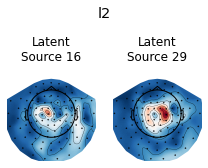

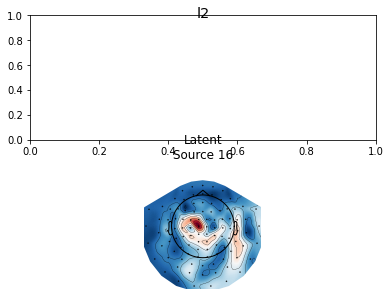

In [236]:
from utils.data_management import dict2str
fig = plot_patterns(spatial_parameters.patterns, info, orders.l2[0].ravel(), title='l2')
# print(dict2str(vars(fig)))
# print(dict2str(vars(fig._localaxes.as_list()[0])))

fig, axs = plt.subplots(2, 1)

plot_patterns(spatial_parameters.patterns, info, orders.l2[0].ravel()[0], title='l2', axes=axs[1])

plt.show()